In [39]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from compartments import *
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]

    #calculate parameters
    #systemic
    p_la = la.p(v_la,t)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)

    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)

    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                       dq_av, dq_mv, 
                       dxi_av, dxi_mv, 
                       dpa, 
                       dv_rv, dv_ra, 
                       dq_tv, dq_pv, 
                       dxi_tv, dxi_pv, 
                       dpb])
    return dy
t_step = 0.01
t_end = 10
t = [0,t_end]
t_span=np.arange(0, t_end, t_step)
T = 0.8
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 3, Emin = 0.08, V0 = 10,T = T, deltat = t_step)
rv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 0.8, Emin = 0.04, V0 = 10, T = T, deltat = t_step)
la=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.17, Emin = 0.08, V0 = 3,T = T, deltat = t_step, delay = 0.85*T)
ra=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.15, Emin = 0.04, V0 = 3, T = T, deltat = t_step, delay = 0.85*T)
av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, Kvo = 0.12,Kvc = 0.15, p_oc = 0)
mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, Kvo = 0.3,Kvc = 0.4, p_oc = 0)
tv=ValveinP(1.06,2,6, 0.3,0.4, 0)
pv=ValveinP(1.06,1.9,2.8, 0.2,0.2, 0) #poc
cap_s=PressureSystem(0.00061, 103.44867, 1471.26289)
cap_p=PressureSystem(0.00272, 26.6, 165)
Emax, Emax_rv, rate = [], 0.8, []
num = 1/t_step
index_range = slice(int(8*num*T), int(9*num*T))

#initial condition
y_initial = np.array([135, 27, #vlv, vla
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb

#integration
sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
sol.t = sol.t
v_rv = sol.y[7]
v_lv = sol.y[0]
v_la = sol.y[1]
v_ra = sol.y[8]
q_av = sol.y[2]
pa = sol.y[6]
q_pv = sol.y[10]
pb = sol.y[13]
p_lv, p_rv, p_la, p_ra, p_pa, p_ao = [], [], [], [], [], []
for i,j in zip(sol.t,range(len(sol.t))):
    p_lv.append(lv.p(v_lv[j], i)/1333)
    p_ao.append(cap_s.pi(q_av[j],pa[j])/1333)
    p_rv.append(rv.p(v_rv[j],i)/1333)
    p_pa.append(cap_p.pi(q_pv[j],pb[j])/1333)
    p_ra.append(ra.p(v_ra[j], i)/1333)
    p_la.append(la.p(v_la[j], i)/1333)

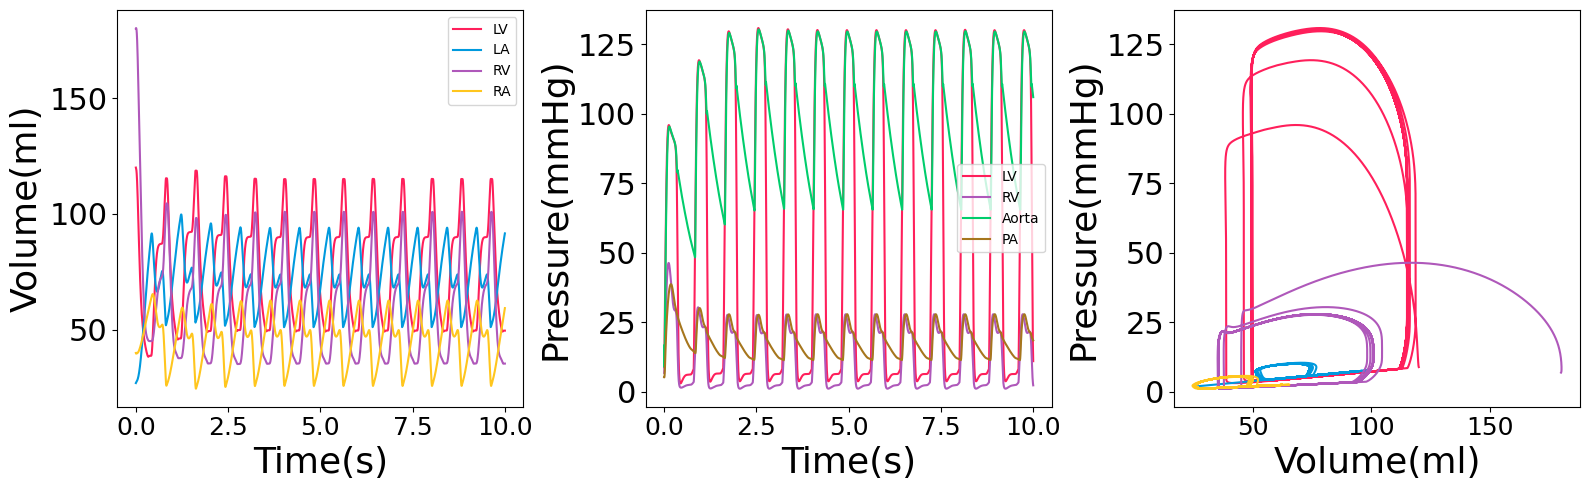

In [28]:
LV = '#FF1F5B'
LA = '#009ADE'
RV = '#AF58BA'
RA = '#FFC61E'
AO = '#00CD6C'
PA = '#A6761D'
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(16,5))
ax1.plot(sol.t, v_lv, label='LV',color = LV)
ax1.plot(sol.t, v_la, label='LA',color = LA)
ax1.plot(sol.t, v_rv, label='RV', color = RV)
ax1.plot(sol.t, v_ra, label='RA', color = RA)
ax1.set_ylabel('Volume(ml)', fontsize = 26)
ax1.legend()
#ax1.set_xlim(8,8.8)
ax1.set_xlabel('Time(s)', fontsize = 26)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=22)
ax2.plot(sol.t, p_lv, label='LV',  color = LV)
ax2.plot(sol.t, p_rv, label = 'RV', color = RV)
ax2.plot(sol.t, p_ao, label='Aorta', color = AO)
ax2.plot(sol.t, p_pa, label = 'PA', color = PA)
ax2.set_ylabel('Pressure(mmHg)', fontsize = 26)
ax2.legend()
ax2.set_xlabel('Time(s)', fontsize = 26)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=22)
ax3.plot(v_lv, p_lv, label='LV', color = LV)
ax3.plot(v_la, p_la, label='LA', color = LA)
ax3.plot(v_rv, p_rv, label='RV', color = RV)
ax3.plot(v_ra, p_ra, label='RA', color = RA)
ax3.set_ylabel('Pressure(mmHg)', fontsize = 26)
ax3.set_xlabel('Volume(ml)', fontsize = 26)
ax3.tick_params(axis='x', labelsize=18)
ax3.tick_params(axis='y', labelsize=22) 
plt.tight_layout()
plt.show()